## Introduction

This is a sample binary classification algorithm used to figure out if a patient has heart disease. In this example, we will upload sample data from Cleveland Heart Disease dataset taken from the UCI repository.  The dataset consists of 303 individuals data.  Please see data repository for column description and sample data.
https://archive.ics.uci.edu/ml/datasets/heart+Disease.  You can download the sample data, place the data in an S3 bucket, and execute the cells in this notebook to build and deploy you own model. 

The rest of this tutorial walks you through using binary classification algorithm to predict heart disease.


## Prequisites and Preprocessing

### Permissions and environment variables

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.  Once you have created your S3 bucket, specify the bucket name and prefix.
- The IAM role arn used to give training and hosting access to your data.

In [1]:
#Enter bucket name
bucket = 'sagemaker-team1'
prefix = 'sagemaker/heart'

#Enter data file name (e.g. heart.csv)
data_key = 'heart.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

### Data ingestion

Prior to data ingestion, please make sure your data set (e.g. heart_data.csv) from the UCI repository is uploaded to an S3 bucket.  By default, SageMaker role has access to buckets that start with 'sageMaker*'.  The code below reads the data from the specified S3 bucket and prints out a sample of it.


In [2]:
import pandas as pd
import json

# read the data from S3
heart_data = pd.read_csv(data_location)

#print out a sample of data.
heart_data.head(10)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [4]:
!pip install matplotlib

In [32]:
positive_points = heart_data[heart_data["output"]==0]

In [36]:
negative_points = heart_data[heart_data["output"]==1]

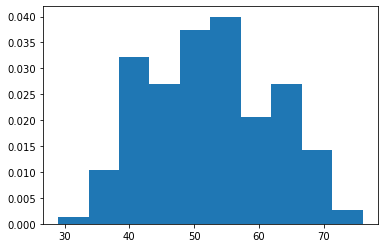

In [37]:
from matplotlib import pyplot as plt
plt.hist(negative_points["age"].values,density=True)
plt.show()

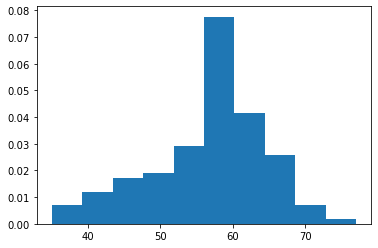

In [38]:
plt.hist(positive_points["age"].values,density=True)
plt.show()

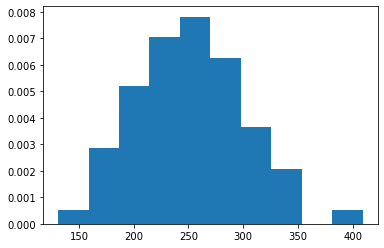

In [39]:
plt.hist(positive_points["chol"].values,density=True)
plt.show()

Observation:
* People with age 60 prone to have an heart attack

In [16]:
 heart_data["cp"].values.shape

(303,)

In [5]:
heart_data["output"].unique()


array([1, 0])

### Data conversion

Since algorithms have particular input and output requirements, converting the dataset is also part of the process that a data scientist goes through prior to initiating training. In this particular case, the Amazon SageMaker implementation of Linear Learner takes recordIO-wrapped protobuf.

The code below performs the following:

Take the data and convert to a numpy array. It has to be of type float32, as that is what the SageMaker Linear Learner algorithm expects.

The linear learner algorithm requires a data matrix, with rows representing the observations, and columns representing the dimensions of the features. It also requires an additional column that contains the labels that match the data points.

For input, you give the model labeled examples (x, y). x is a high-dimensional vector and y is a numeric label. For binary classification problems, the label must be either 0 or 1


The Linear Learner algorithms expects a features matrix and labels vector.

The labels column is our 'target' column.  In this case, we want to predict the last column to determine if the user has heart disease.  A value of 1 indicates the presence of heart disease and zero does not. 

In [6]:
import numpy as np
vectors = np.array(heart_data).astype('float32')

#target column - value must be either 0 or 1
labels = vectors[:,13]
print ("label data is")
print (labels)


#drop the target column.  Use the features as part of the training data
training_data = vectors[:, :13]
print ("Training data is")
print (training_data)



label data is
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Training data is
[[63.  1.  3. ...  0.  0.  1.]
 [37.  1.  2. .

Let's go ahead and upload the training data to S3

In [7]:
import io
import os
import sagemaker.amazon.common as smac

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, training_data, labels)
buf.seek(0)

key = 'recordio-pb-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))




uploaded training data location: s3://sagemaker-team1/sagemaker/heart/train/recordio-pb-data


## Training Artifacts
Once data is trained, it will be uploaded to the following location.

In [8]:
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://sagemaker-team1/sagemaker/heart/output


## Training the linear model

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. Since this data is relatively small, it isn't meant to show off the performance of the Linear Learner training algorithm.

Again, we'll use the Amazon SageMaker Python SDK to kick off training, and monitor status until it is completed.  In this example that takes between 7 and 11 minutes.  Despite the dataset being small, provisioning hardware and loading the algorithm container take time upfront.

We will do a binary classification (patient either has heart disease or not), train the model on the specified compute (e.g. c4.xlarge), and we will sepcify the features or dimiensions in our training set.

In [9]:
import sagemaker
sagemaker.__version__

'2.31.1'

In [10]:
!pip install sagemaker==1.72.0

     |████████████████████████████████| 297 kB 20.3 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-1.72.0-py2.py3-none-any.whl size=386358 sha256=f3839228c2e41de727bcf869b46424d6555ba3b3fbda13d924f8104d90175e8a
  Stored in directory: /home/ec2-user/.cache/pip/wheels/c3/58/70/85faf4437568bfaa4c419937569ba1fe54d44c5db42406bbd7
Successfully built sagemaker
  Attempting uninstall: smdebug-rulesconfig
    Found existing installation: smdebug-rulesconfig 1.0.1
    Uninstalling smdebug-rulesconfig-1.0.1:
      Successfully uninstalled smdebug-rulesconfig-1.0.1
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.31.1
    Uninstalling sagemaker-2.31.1:
      Successfully uninstalled sagemaker-2.31.1


In [11]:
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker
import warnings
warnings.filterwarnings("ignore")


container = get_image_uri(boto3.Session().region_name, 'linear-learner', "latest")

#container = sagemaker.image_uris.retrieve(boto3.Session().region_name, 'linear-learner', "latest")

sess = sagemaker.Session()
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       train_instance_count=1, 
                                       train_instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess)
linear.set_hyperparameters(feature_dim=13,
                           predictor_type='binary_classifier',
                           mini_batch_size=100)

linear.fit({'train': s3_train_data})

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


FileNotFoundError: [Errno 2] No such file or directory: '/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sagemaker/image_uri_config/linear-learner.json'

## Set up hosting for the model
Now that we've trained our model, we can deploy it behind an Amazon SageMaker real-time hosted endpoint.  This will allow out to make predictions (or inference) from the model dyanamically.

_Note, Amazon SageMaker allows you the flexibility of importing models trained elsewhere, as well as the choice of not importing models if the target of model creation is AWS Lambda, AWS Greengrass, Amazon Redshift, Amazon Athena, or other deployment target._

In [ ]:
heartdisease_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

## Validate the model for use
Finally, we can now validate the model for use.  We can pass HTTP POST requests to the endpoint to get back predictions.  To make this easier, we'll again use the Amazon SageMaker Python SDK and specify how to serialize requests and deserialize responses that are specific to the algorithm.

In [ ]:
from sagemaker.predictor import csv_serializer, json_deserializer

heartdisease_predictor.content_type = 'text/csv'
heartdisease_predictor.serializer = csv_serializer
heartdisease_predictor.deserializer = json_deserializer

In [ ]:
print('Endpoint name: {}'.format(heartdisease_predictor.endpoint))

Let's try passing the following sample data for testing. This is a single record from the file

In [ ]:
vectors[5][0:13]

In [ ]:
result = heartdisease_predictor.predict(vectors[5][0:13])
print(result)

In [ ]:
import sagemaker

sagemaker.Session().delete_endpoint(heartdisease_predictor.endpoint)

### (Optional) Delete the Endpoint

If you're ready to be done with this notebook, please run the delete_endpoint line in the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.